In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
import scipy.signal

In [2]:
uploaded = files.upload()

Saving alpha1_metrics.csv to alpha1_metrics (1).csv
Saving alpha0_metrics.csv to alpha0_metrics (1).csv
Saving alpha05_metrics.csv to alpha05_metrics (1).csv
Saving alpha02_metrics.csv to alpha02_metrics (1).csv
Saving alpha08_metrics.csv to alpha08_metrics (1).csv


In [3]:
dfs = {}

for filename in uploaded.keys():
    name = filename.split(".")[0]  # use filename as ID
    df = pd.read_csv(filename)
    df["source"] = name  # tag the source
    dfs[name] = df

In [4]:
combined_df = pd.concat(dfs.values(), ignore_index=True) # for  one big group-level analysis

In [5]:
# (kl loss) 0 <= alpha <= 1 (next_token loss)

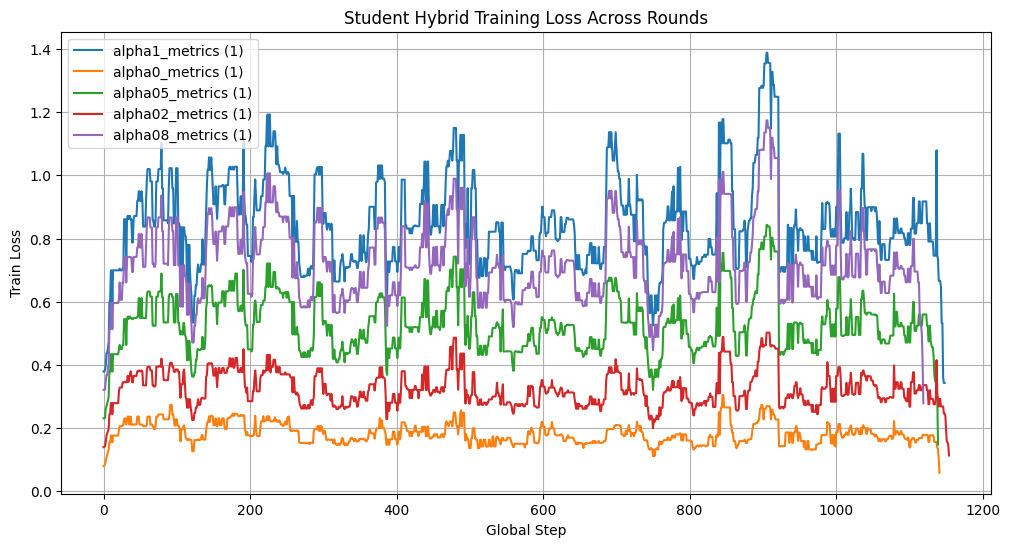

In [29]:
# Student train loss (hybrid) over rounds
plt.figure(figsize=(12, 6))

for name, df in dfs.items():
    student_train_df = df[
        (df["role"] == "student") &
        (df["phase"] == "train") &
        (df["function"] == "compute_loss")
    ].sort_values(by=["round", "step"]).reset_index(drop=True)

    student_train_df["global_step"] = range(len(student_train_df))
    smoothed_loss = scipy.signal.medfilt(student_train_df["train_loss"], 21)

    plt.plot(student_train_df["global_step"], smoothed_loss, label=f"{name}")

plt.title("Student Hybrid Training Loss Across Rounds")
plt.xlabel("Global Step")
plt.ylabel("Train Loss")
plt.legend()
plt.grid(True)
plt.show()

# TODO: add round boundary

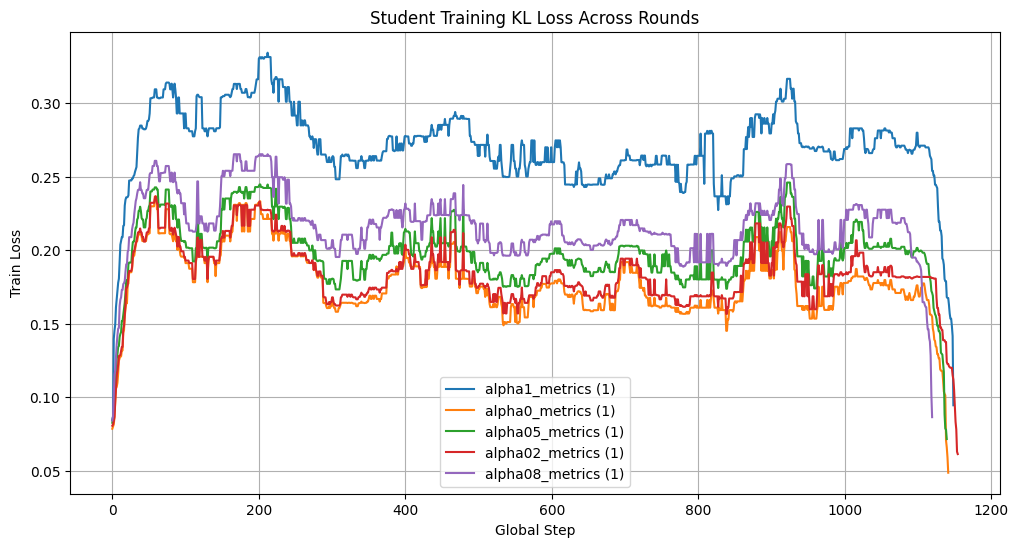

In [14]:
# Student train loss (kl) over rounds
plt.figure(figsize=(12, 6))

for name, df in dfs.items():
    student_train_df = df[
        (df["role"] == "student") &
        (df["phase"] == "train") &
        (df["function"] == "compute_loss")
    ].sort_values(by=["round", "step"]).reset_index(drop=True)

    student_train_df["global_step"] = range(len(student_train_df))
    smoothed_loss = scipy.signal.medfilt(student_train_df["train_kl_loss"], 71)

    plt.plot(student_train_df["global_step"], smoothed_loss, label=f"{name}")

plt.title("Student Training KL Loss Across Rounds")
plt.xlabel("Global Step")
plt.ylabel("Train Loss")
plt.legend()
plt.grid(True)
plt.show()

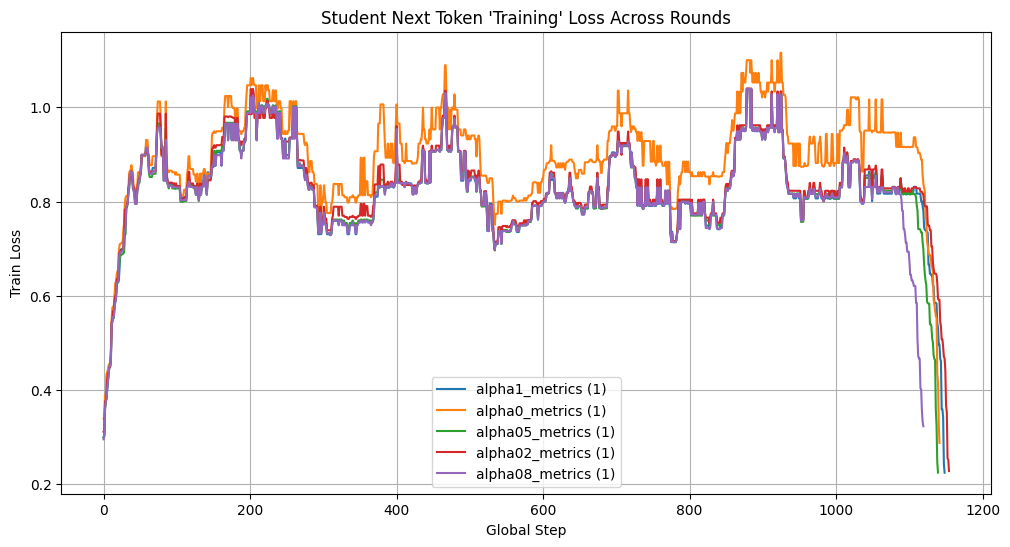

In [22]:
# Student train loss (next token) over rounds
plt.figure(figsize=(12, 6))

for name, df in dfs.items():
    student_train_df = df[
        (df["role"] == "student") &
        (df["phase"] == "train") &
        (df["function"] == "compute_loss")
    ].sort_values(by=["round", "step"]).reset_index(drop=True)

    student_train_df["global_step"] = range(len(student_train_df))
    smoothed_loss = scipy.signal.medfilt(student_train_df["train_next_token_loss"], 71)

    plt.plot(student_train_df["global_step"], smoothed_loss, label=f"{name}")

plt.title("Student Next Token 'Training' Loss Across Rounds")
plt.xlabel("Global Step")
plt.ylabel("Train Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Per round logging of training loss ?

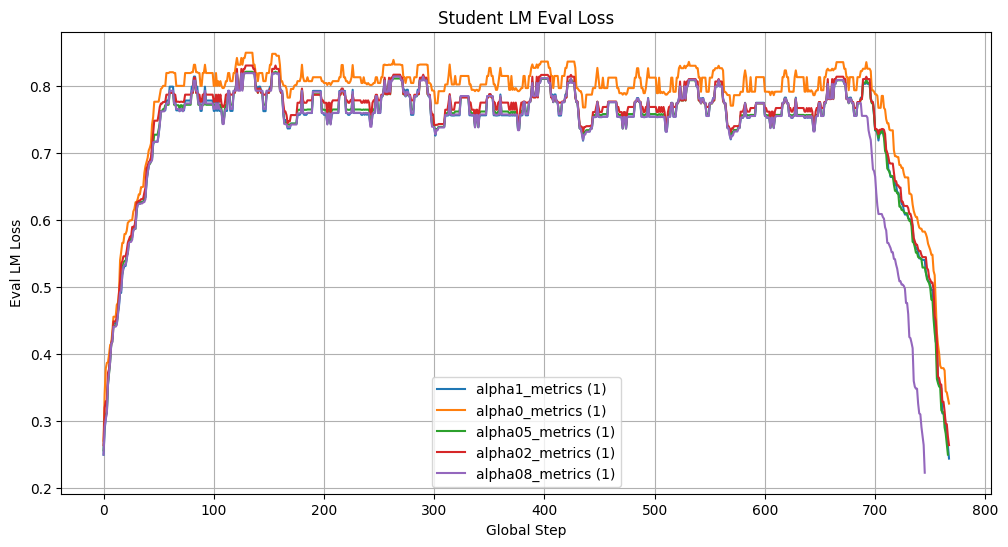

In [24]:
# Per round logging of student LM eval loss
plt.figure(figsize=(12, 6))

for name, df in dfs.items():
    student_eval_df = df[
        (df["role"] == "student") &
        (df["phase"] == "eval") &
        (df["function"] == "prediction_step")
    ].sort_values(by=["round", "step"]).reset_index(drop=True)

    student_eval_df["global_step"] = range(len(student_eval_df))
    smoothed_loss = scipy.signal.medfilt(student_eval_df["eval_loss"], 121)

    plt.plot(student_eval_df["global_step"], smoothed_loss, label=f"{name}")

plt.title("Student LM Eval Loss")
plt.xlabel("Global Step")
plt.ylabel("Eval LM Loss")
plt.legend()
plt.grid(True)
plt.show()

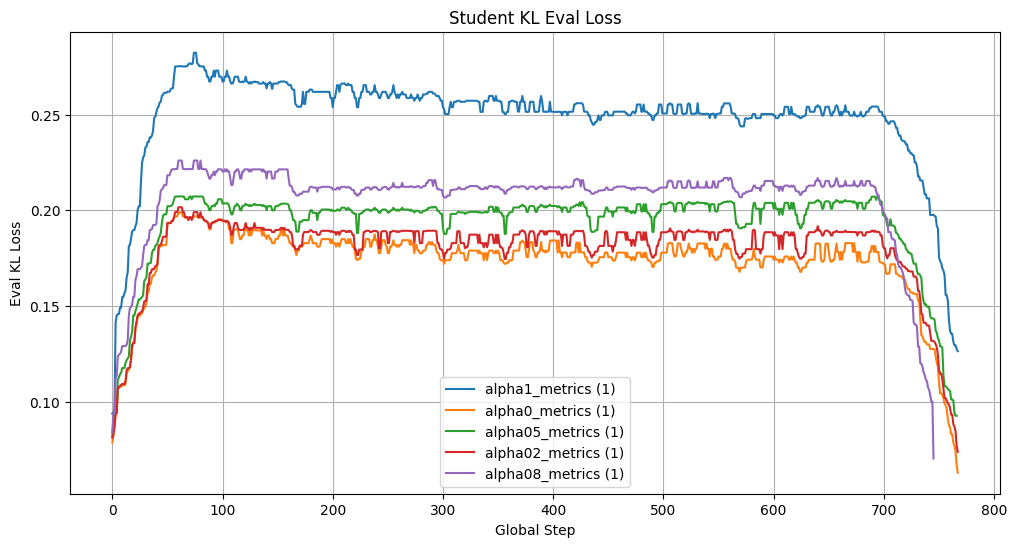

In [25]:
# Per round logging of student kl eval loss
plt.figure(figsize=(12, 6))

for name, df in dfs.items():
    student_eval_df = df[
        (df["role"] == "student") &
        (df["phase"] == "eval") &
        (df["function"] == "prediction_step")
    ].sort_values(by=["round", "step"]).reset_index(drop=True)

    student_eval_df["global_step"] = range(len(student_eval_df))
    smoothed_loss = scipy.signal.medfilt(student_eval_df["eval_kl_loss"], 121)

    plt.plot(student_eval_df["global_step"], smoothed_loss, label=f"{name}")

plt.title("Student KL Eval Loss")
plt.xlabel("Global Step")
plt.ylabel("Eval KL Loss")
plt.legend()
plt.grid(True)
plt.show()

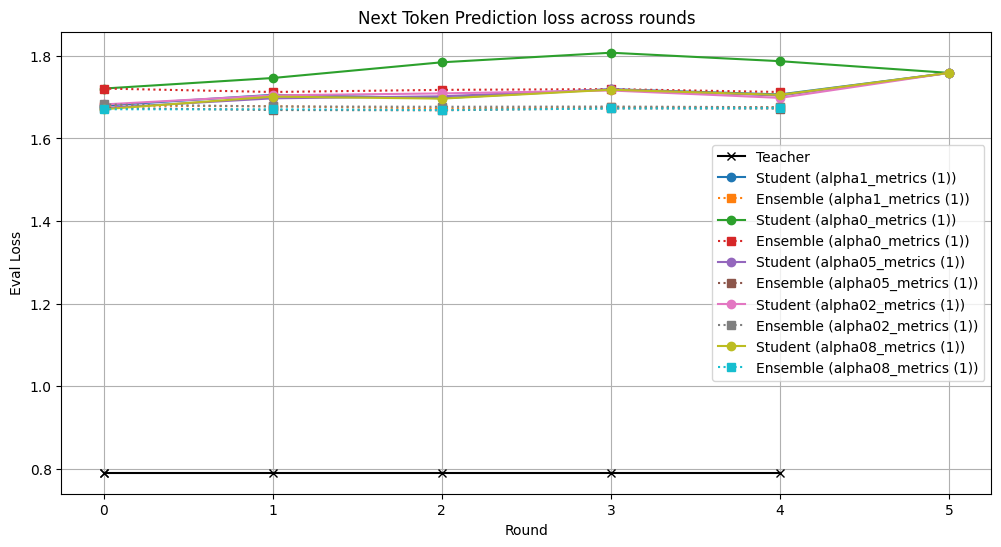

In [26]:
# Student vs Teacher vs Ensemble performance over rounds on next_token_prediction, custom evaluation method
plt.figure(figsize=(12, 6))

first_run_id = list(dfs.keys())[0]
df_teacher = dfs[first_run_id]
df_teacher = df_teacher[
    (df_teacher["phase"] == "custom_eval") &
    (df_teacher["role"] == "teacher")
].sort_values("round")

plt.plot(
    df_teacher["round"],
    df_teacher["eval_loss"],
    linestyle="-",
    marker="x",
    color="black",
    label="Teacher"
)

for name, df in dfs.items():
    df_eval = df[df["phase"] == "custom_eval"]

    # --- STUDENT ---
    df = df[~df["tags"].fillna("").str.contains("initial eval")]
    df_student = df_eval[df_eval["role"] == "student"]

    df_student = df_student.sort_values("timestamp")
    df_student = df_student.groupby("round", as_index=False).last()

    plt.plot(
        df_student["round"],
        df_student["eval_loss"],
        linestyle="-",
        marker="o",
        label=f"Student ({name})"
    )

    # --- ENSEMBLE ---
    df_ensemble = df_eval[df_eval["role"] == "ensemble"]
    df_ensemble = df_ensemble.sort_values("timestamp")
    # df_ensemble = df_ensemble.groupby("round", as_index=False).last()

    plt.plot(
        df_ensemble["round"],
        df_ensemble["eval_loss"],
        linestyle=":",
        marker="s",
        label=f"Ensemble ({name})"
    )

plt.xlabel("Round")
plt.ylabel("Eval Loss")
plt.title("Next Token Prediction loss across rounds")
plt.legend()
plt.grid(True)
plt.show()



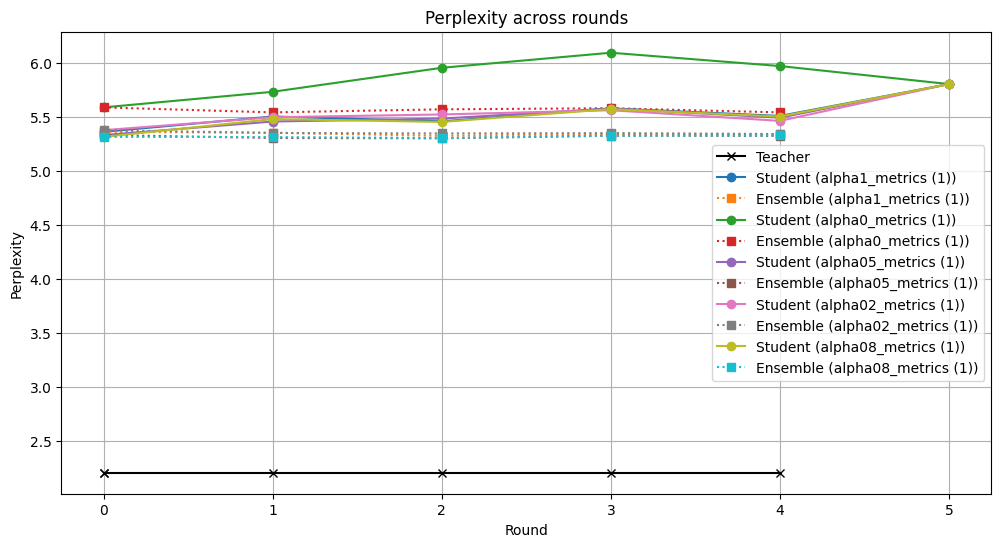

In [27]:
# Student vs Teacher vs Ensemble perplexity over rounds, custom evaluation method
plt.figure(figsize=(12, 6))

first_run_id = list(dfs.keys())[0]
df_teacher = dfs[first_run_id]
df_teacher = df_teacher[
    (df_teacher["phase"] == "custom_eval") &
    (df_teacher["role"] == "teacher")
].sort_values("round")

plt.plot(
    df_teacher["round"],
    df_teacher["perplexity"],
    linestyle="-",
    marker="x",
    color="black",
    label="Teacher"
)

for name, df in dfs.items():
    df_eval = df[df["phase"] == "custom_eval"]

    # --- STUDENT ---
    df = df[~df["tags"].fillna("").str.contains("initial eval")]
    df_student = df_eval[df_eval["role"] == "student"]

    df_student = df_student.sort_values("timestamp")
    df_student = df_student.groupby("round", as_index=False).last()

    plt.plot(
        df_student["round"],
        df_student["perplexity"],
        linestyle="-",
        marker="o",
        label=f"Student ({name})"
    )

    # --- ENSEMBLE ---
    df_ensemble = df_eval[df_eval["role"] == "ensemble"]
    df_ensemble = df_ensemble.sort_values("timestamp")
    df_ensemble = df_ensemble.groupby("round", as_index=False).last()

    plt.plot(
        df_ensemble["round"],
        df_ensemble["perplexity"],
        linestyle=":",
        marker="s",
        label=f"Ensemble ({name})"
    )

plt.xlabel("Round")
plt.ylabel("Perplexity")
plt.title("Perplexity across rounds")
plt.legend()
plt.grid(True)
plt.show()


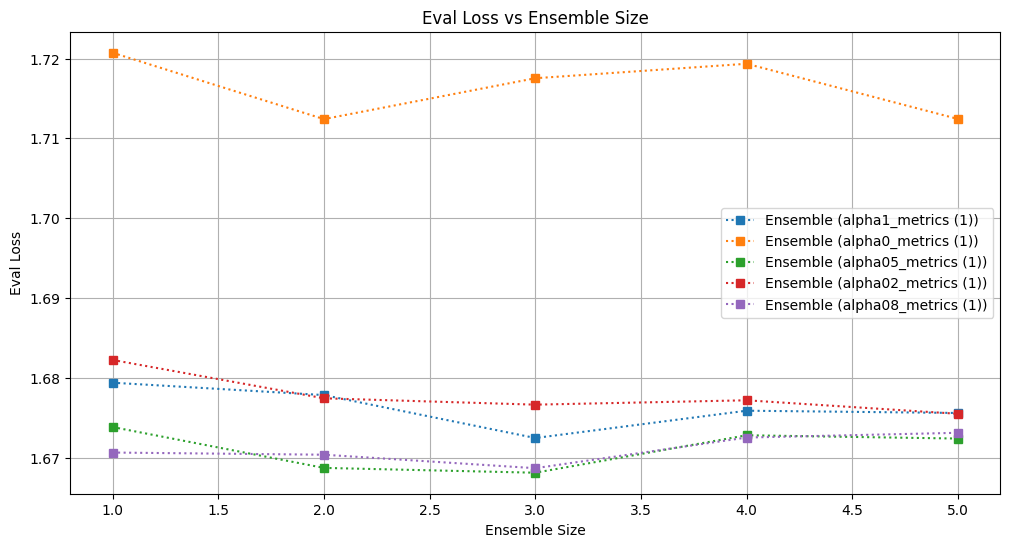

In [30]:
# Eval loss vs ensemble size
plt.figure(figsize=(12, 6))

# Plot teacher once (constant)
first_run_id = list(dfs.keys())[0]
df_teacher = dfs[first_run_id]
df_teacher = df_teacher[
    (df_teacher["role"] == "teacher") &
    (df_teacher["phase"] == "custom_eval")
]

# plt.plot(
#     df_teacher["ensemble_num"],
#     df_teacher["eval_loss"],
#     label="Teacher",
#     marker="x",
#     color="black"
# )

# Plot ensemble eval_loss vs ensemble_size per file
for name, df in dfs.items():
    df_ensemble = df[
        (df["role"] == "ensemble") &
        (df["phase"] == "custom_eval")
    ]

    plt.plot(
        df_ensemble["ensemble_num"],  # or "ensemble_size"
        df_ensemble["eval_loss"],
        marker="s",
        linestyle=":",
        label=f"Ensemble ({name})"
    )

plt.xlabel("Ensemble Size")
plt.ylabel("Eval Loss")
plt.title("Eval Loss vs Ensemble Size")
plt.grid(True)
plt.legend()
plt.show()
